# OpenPose
## Find the keypoints for a image with only single person

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

# MPII에서 각 파트 번호, 선으로 연결될 POSE_PAIRS
elif MODE is "MPI" :
    protoFile = "/content/drive/MyDrive/Human Pose Estimation/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "/content/drive/MyDrive/Human Pose Estimation/pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

In [4]:
# 이미지 읽어오기
frame = cv2.imread("/content/drive/MyDrive/Human Pose Estimation/dataset/vasisthasana/15-0.png")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

In [5]:
# 위의 path에 있는 network 불러오기
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# 불러온 이미지에서 height, width, color 받아옴
inWidth = 368
inHeight = 368

# network에 넣기위해 전처리
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
# network에 넣어주기
net.setInput(inpBlob)

# 결과 받아오기
output = net.forward()
# output.shape[0] = 이미지 ID, [1] = 출력 맵의 높이, [2] = 너비
H = output.shape[2]
W = output.shape[3]
print("이미지 ID : ", len(output[0]), ", H : ", output.shape[2], ", W : ",output.shape[3]) # 이미지 ID

이미지 ID :  44 , H :  46 , W :  46


[(23, 248), (80, 282), (80, 327), (69, 406), (34, 485), (104, 270), (69, 259), (80, 270), (231, 372), (346, 428), None, (254, 327), None, (462, 473), (161, 315)]


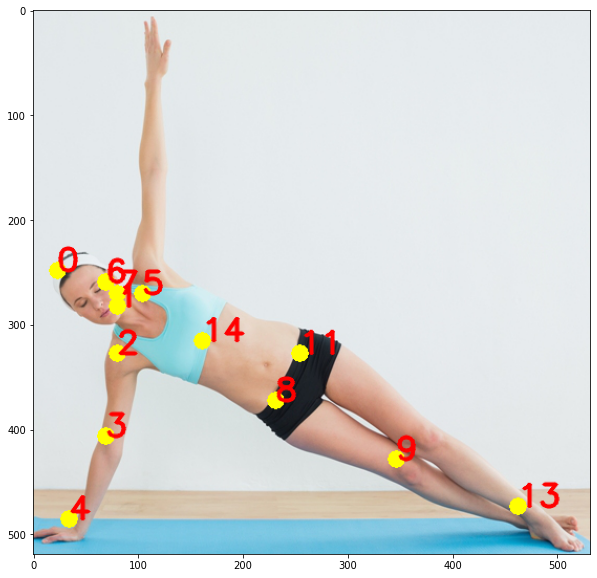

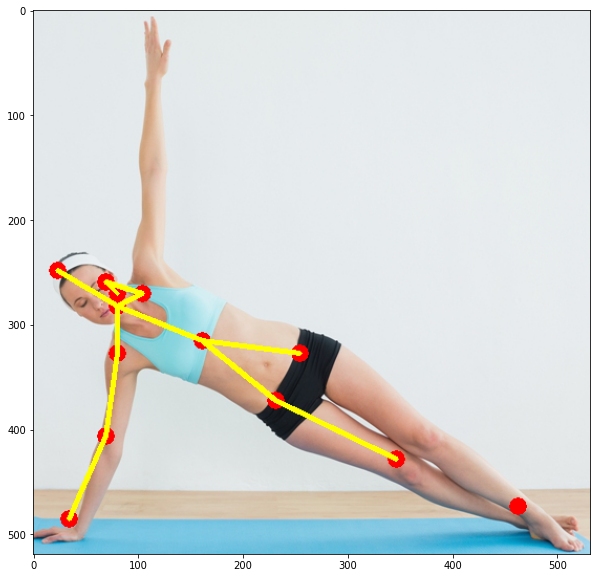

In [8]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    # 해당 신체부위 신뢰도 얻음.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
     # global 최대값 찾기
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    # 원래 이미지에 맞게 점 위치 변경
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H


    # 키포인트 검출한 결과가 0.1보다 크면(검출한곳이 위 BODY_PARTS랑 맞는 부위면) points에 추가, 검출했는데 부위가 없으면 None으로 
    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
# 각 POSE_PAIRS별로 선 그어줌 (머리 - 목, 목 - 왼쪽어깨, ...)
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

print(points)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))